In [1]:
#/kaggle/input/malicious-urls-dataset/malicious_phish.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from urllib.parse import urlparse

from IPython.display import display, Markdown
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

import sys, os, yaml

DATASET = "Kaggle"

ROOT = "./"
COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"


DEBUG = False
SEED = 1612

In [2]:
if COLAB:
    from google.colab import drive
    if not os.path.isdir("/content/gdrive"):
        drive.mount("/content/gdrive")
        d = "/content/gdrive/MyDrive/datasets"
        if not os.path.isdir(d): os.makedirs(d)
        if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
    if COLAB:
        if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
    else:
        if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

In [3]:
def convert_column_to_boolean(df, column_name):
    df[column_name] = df[column_name].astype(bool)
    return df

In [4]:
df = pd.read_csv(f"{ROOT}/malicious_phish.csv")
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
def label_type(row):
    if row['type'] == 'benign':
        return 0
    else:
        return 1

# Apply the function to create a new column
df['Label'] = df.apply(label_type, axis=1)

# Show the modified DataFrame
print(df)

                                                      url        type  Label
0                                        br-icloud.com.br    phishing      1
1                     mp3raid.com/music/krizz_kaliko.html      benign      0
2                         bopsecrets.org/rexroth/cr/1.htm      benign      0
3       http://www.garage-pirenne.be/index.php?option=...  defacement      1
4       http://adventure-nicaragua.net/index.php?optio...  defacement      1
...                                                   ...         ...    ...
651186            xbox360.ign.com/objects/850/850402.html    phishing      1
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing      1
651188         www.gamespot.com/xbox360/action/deadspace/    phishing      1
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing      1
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing      1

[651191 rows x 3 columns]


In [7]:
df = convert_column_to_boolean(df, 'Label')

In [8]:
df = df.drop(columns=['type'])

In [9]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)

In [10]:
df['url_len'] = df['url'].apply(lambda x: get_url_length(str(x)))

In [11]:
df.head()

,url,Label,url_len
0,br-icloud.com.br,True,16
1,mp3raid.com/music/krizz_kaliko.html,False,35
2,bopsecrets.org/rexroth/cr/1.htm,False,31
3,http://www.garage-pirenne.be/index.php?option=...,True,77
4,http://adventure-nicaragua.net/index.php?optio...,True,228


In [14]:
df.head()

,url,Label,url_len
0,br-icloud.com.br,True,16
1,mp3raid.com/music/krizz_kaliko.html,False,35
2,bopsecrets.org/rexroth/cr/1.htm,False,31
3,http://www.garage-pirenne.be/index.php?option=...,True,77
4,http://adventure-nicaragua.net/index.php?optio...,True,228


In [15]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = set(string.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

In [16]:
df['letters_count']        = df['url'].apply(lambda x: count_letters(x))
df['digits_count']         = df['url'].apply(lambda x: count_digits(x))
df['special_chars_count']  = df['url'].apply(lambda x: count_special_chars(x))

In [17]:
df.head()

,url,Label,url_len,letters_count,digits_count,special_chars_count
0,br-icloud.com.br,True,16,13,0,3
1,mp3raid.com/music/krizz_kaliko.html,False,35,29,1,5
2,bopsecrets.org/rexroth/cr/1.htm,False,31,25,1,5
3,http://www.garage-pirenne.be/index.php?option=...,True,77,63,7,18
4,http://adventure-nicaragua.net/index.php?optio...,True,228,199,22,14


In [18]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

In [19]:
df['secure_http']  = df['url'].apply(lambda x: secure_http(x))

In [20]:
df = convert_column_to_boolean(df, 'secure_http')

In [21]:
df.head()

,url,Label,url_len,letters_count,digits_count,special_chars_count,secure_http
0,br-icloud.com.br,True,16,13,0,3,False
1,mp3raid.com/music/krizz_kaliko.html,False,35,29,1,5,False
2,bopsecrets.org/rexroth/cr/1.htm,False,31,25,1,5,False
3,http://www.garage-pirenne.be/index.php?option=...,True,77,63,7,18,False
4,http://adventure-nicaragua.net/index.php?optio...,True,228,199,22,14,False


In [22]:
import ipaddress
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass  # Invalid hostname or IP address

    return 0

In [23]:
df['have_ip']  = df['url'].apply(lambda x: have_ip_address(x))

In [24]:
df = convert_column_to_boolean(df, 'have_ip')

In [25]:
df.head()

,url,Label,url_len,letters_count,digits_count,special_chars_count,secure_http,have_ip
0,br-icloud.com.br,True,16,13,0,3,False,False
1,mp3raid.com/music/krizz_kaliko.html,False,35,29,1,5,False,False
2,bopsecrets.org/rexroth/cr/1.htm,False,31,25,1,5,False,False
3,http://www.garage-pirenne.be/index.php?option=...,True,77,63,7,18,False,False
4,http://adventure-nicaragua.net/index.php?optio...,True,228,199,22,14,False,False


In [26]:
df.isnull().sum()

url                    0
Label                  0
url_len                0
letters_count          0
digits_count           0
special_chars_count    0
secure_http            0
have_ip                0
dtype: int64

In [27]:
df.head()

,url,Label,url_len,letters_count,digits_count,special_chars_count,secure_http,have_ip
0,br-icloud.com.br,True,16,13,0,3,False,False
1,mp3raid.com/music/krizz_kaliko.html,False,35,29,1,5,False,False
2,bopsecrets.org/rexroth/cr/1.htm,False,31,25,1,5,False,False
3,http://www.garage-pirenne.be/index.php?option=...,True,77,63,7,18,False,False
4,http://adventure-nicaragua.net/index.php?optio...,True,228,199,22,14,False,False


In [28]:
df.isnull().sum()

url                    0
Label                  0
url_len                0
letters_count          0
digits_count           0
special_chars_count    0
secure_http            0
have_ip                0
dtype: int64

In [29]:
#df.fillna(0,inplace=True)

In [30]:
df.isnull().sum()

url                    0
Label                  0
url_len                0
letters_count          0
digits_count           0
special_chars_count    0
secure_http            0
have_ip                0
dtype: int64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   url                  651191 non-null  object
 1   Label                651191 non-null  bool  
 2   url_len              651191 non-null  int64 
 3   letters_count        651191 non-null  int64 
 4   digits_count         651191 non-null  int64 
 5   special_chars_count  651191 non-null  int64 
 6   secure_http          651191 non-null  bool  
 7   have_ip              651191 non-null  bool  
dtypes: bool(3), int64(4), object(1)
memory usage: 26.7+ MB


In [32]:
import re
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    
    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'short', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd', 
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur', 
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is', 
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl', 
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0         

In [33]:
df['shortened']  = df['url'].apply(lambda x: has_shortening_service(x))

In [34]:
df = convert_column_to_boolean(df, 'shortened')

In [35]:
df.head()

,url,Label,url_len,letters_count,digits_count,special_chars_count,secure_http,have_ip,shortened
0,br-icloud.com.br,True,16,13,0,3,False,False,False
1,mp3raid.com/music/krizz_kaliko.html,False,35,29,1,5,False,False,False
2,bopsecrets.org/rexroth/cr/1.htm,False,31,25,1,5,False,False,False
3,http://www.garage-pirenne.be/index.php?option=...,True,77,63,7,18,False,False,False
4,http://adventure-nicaragua.net/index.php?optio...,True,228,199,22,14,False,False,False


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   url                  651191 non-null  object
 1   Label                651191 non-null  bool  
 2   url_len              651191 non-null  int64 
 3   letters_count        651191 non-null  int64 
 4   digits_count         651191 non-null  int64 
 5   special_chars_count  651191 non-null  int64 
 6   secure_http          651191 non-null  bool  
 7   have_ip              651191 non-null  bool  
 8   shortened            651191 non-null  bool  
dtypes: bool(4), int64(4), object(1)
memory usage: 27.3+ MB


In [37]:
df.duplicated().sum()

10066

In [39]:
df.drop_duplicates(inplace=True)

In [40]:
data = df.drop(columns=['url'])

In [41]:
data.columns

Index(['Label', 'url_len', 'letters_count', 'digits_count',
       'special_chars_count', 'secure_http', 'have_ip', 'shortened'],
      dtype='object')

In [42]:
data.head()

,Label,url_len,letters_count,digits_count,special_chars_count,secure_http,have_ip,shortened
0,True,16,13,0,3,False,False,False
1,False,35,29,1,5,False,False,False
2,False,31,25,1,5,False,False,False
3,True,77,63,7,18,False,False,False
4,True,228,199,22,14,False,False,False


In [43]:
#target = data['Label']
#df_train, df_test = train_test_split(data, stratify=data.Label, test_size=.40, random_state=132)
#features = data.columns.tolist()
#features.remove('Label')
#if target in features: features.remove(target)
#print(f"Number of features {len(features)}\n{features}")



from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'Lable' is a typo for 'Label'

target = data['Label']  # Corrected spelling from 'Lable' to 'Label'
df_train, df_test = train_test_split(data, stratify=data.Label, test_size=0.40, random_state=132)  # Using the correct column name 'Label'

features = data.columns.tolist()
features.remove('Label')  # Corrected spelling

# Instead of scaling, directly use the feature values
X_train = df_train.loc[:, features].values
y_train = df_train.Label.values  # Using the correct column name 'Label'

X_test = df_test.loc[:, features].values
y_test = df_test.Label.values  # Using the correct column name 'Label'


In [44]:
features

['url_len',
 'letters_count',
 'digits_count',
 'special_chars_count',
 'secure_http',
 'have_ip',
 'shortened']

In [45]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()

#X_train = scaler.fit_transform(df_train.loc[:,features].values)
#y_train = df_train.Label.values

#X_test = scaler.transform(df_test.loc[:,features].values)
#y_test = df_test.Label.values

In [46]:
X_train.shape

(384675, 7)

In [47]:
y_train.shape

(384675,)

In [48]:
!pip install xgboost > NUL 2>&1
print("installed")

installed


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [51]:
models = {
   "LR": LogisticRegression(solver ='liblinear'),
    "DT": DecisionTreeClassifier(),
    "DT(max_depth=3)": DecisionTreeClassifier(max_depth=3),
    "KNN": KNeighborsClassifier(),
  #  "SVC": SVC(),
    "ADA": AdaBoostClassifier(),
    "RFC":  RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "NB" : GaussianNB()

}

def train_models():
    best = {'name':None, 'mean':0}

    for name,model in models.items():

        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
        mean = scores.mean()
        std = scores.std()

        print ("\nModel %s" % name)
        print ("\tCV scores: " +  ", ".join([f"{s:.2f}" for s in scores]))
        print (f"\tmean={mean:.2%} std={std:.4f}")

        if mean>best['mean']:
            best = {'name':name, 'mean':mean}

    print (f"\nBest Performing Model {best['name']} with (mean CV of) accuracy = {best['mean']:.2%}" )


In [61]:
model = XGBClassifier()
#model = RandomForestClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [62]:
def get_url_length(url):
    return len(url)

def count_letters(url):
    return sum(char.isalpha() for char in url)

def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    return sum(char in special_chars for char in url)

def has_shortening_service(url):
    pattern = re.compile(r'(bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net)')
    return int(bool(pattern.search(url)))

def secure_http(url):
    return int(urlparse(url).scheme == 'https')

def have_ip_address(url):
    pattern = re.compile(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)')
    return int(bool(pattern.search(url)))


### Testing

In [63]:
def get_numerical_values(url):
    url = url.replace('www.', '')
    parsed_url  = urlparse(url)
    root_domain = parsed_url.netloc
   # url_region = get_url_region(root_domain)
   
    #root_domain = extract_root_domain(url)
    
    numerical_values = {
        'url_len': get_url_length(url),
        'letters_count': count_letters(url),
        'digits_count': count_digits(url),
        'special_chars_count': count_special_chars(url),
        #'url_region': hash_encode(url_region),
        #'root_domain': hash_encode(root_domain)
    }
    return numerical_values

In [64]:
def get_bool_values(url):
    url = url.replace('www','')
    parsed_url = urlparse(url)
    
    bool_values = {
        'secure_http': secure_http(url),
        'have_ip': have_ip_address(url),
        'shortened': has_shortening_service(url),
    }
    return bool_values

In [147]:
url = 'http://www.vilagnomad.com/wp-content/plugins/cforms146/js/cforms.js'
numerical_values = get_numerical_values(url)
bool_values = get_bool_values(url)
print(numerical_values)
print(bool_values)

{'url_len': 63, 'letters_count': 49, 'digits_count': 3, 'special_chars_count': 11}
{'secure_http': 0, 'have_ip': 0, 'shortened': 0}


In [148]:
combined_features = {**numerical_values, **bool_values}

# Converting combined features into a DataFrame
# The dictionary keys become column names and the values become a single row in the DataFrame
new_data_df = pd.DataFrame([combined_features])
new_data_df['shortened'] = new_data_df['shortened'].astype(bool)
new_data_df['secure_http'] = new_data_df['secure_http'].astype(bool)
new_data_df['have_ip'] = new_data_df['have_ip'].astype(bool)

In [149]:
new_data_df.head()

,url_len,letters_count,digits_count,special_chars_count,secure_http,have_ip,shortened
0,63,49,3,11,False,False,False


In [150]:
new_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   url_len              1 non-null      int64
 1   letters_count        1 non-null      int64
 2   digits_count         1 non-null      int64
 3   special_chars_count  1 non-null      int64
 4   secure_http          1 non-null      bool 
 5   have_ip              1 non-null      bool 
 6   shortened            1 non-null      bool 
dtypes: bool(3), int64(4)
memory usage: 167.0 bytes


In [151]:
# Convert DataFrame to NumPy array to match training format
new_data_array = new_data_df.values

# Predict using the trained model
predictions = model.predict(new_data_array)

# Output the predictions
print("Prediction for the given input:", predictions[0])

Prediction for the given input: 0


In [121]:
new_data_array

array([[20, 16, 0, 4, True, False, False]], dtype=object)

In [128]:
X_train

array([[-0.11512445,  0.15180143, -0.46190264, ..., -0.15788644,
        -0.13834344, -0.01612536],
       [-0.6642104 , -0.63310252, -0.46190264, ..., -0.15788644,
        -0.13834344, -0.01612536],
       [-0.43542458, -0.63310252,  0.65504716, ..., -0.15788644,
        -0.13834344, -0.01612536],
       ...,
       [ 3.40817704,  4.01352887,  1.85791616, ..., -0.15788644,
        -0.13834344, -0.01612536],
       [-0.32103168, -0.22495246, -0.46190264, ..., -0.15788644,
        -0.13834344, -0.01612536],
       [-0.36678884, -0.5703102 ,  0.05361265, ..., -0.15788644,
        -0.13834344, -0.01612536]])

## Evaluation of Metrics

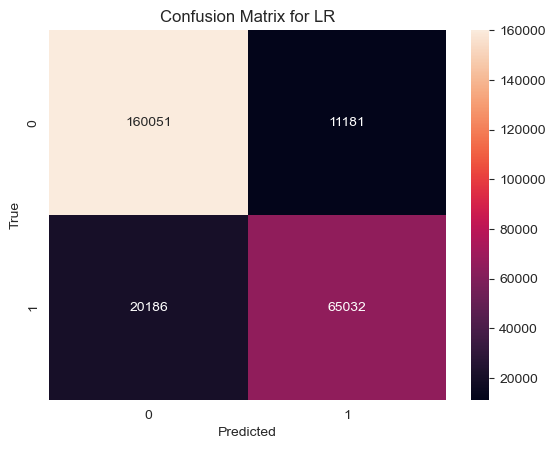

Classification Report for LR:
              precision    recall  f1-score   support

       False       0.89      0.93      0.91    171232
        True       0.85      0.76      0.81     85218

    accuracy                           0.88    256450
   macro avg       0.87      0.85      0.86    256450
weighted avg       0.88      0.88      0.88    256450



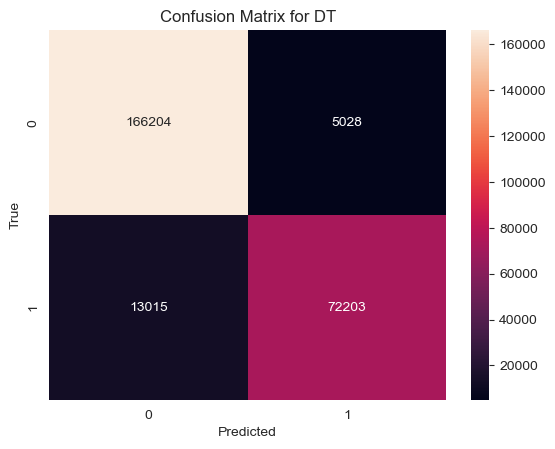

Classification Report for DT:
              precision    recall  f1-score   support

       False       0.93      0.97      0.95    171232
        True       0.93      0.85      0.89     85218

    accuracy                           0.93    256450
   macro avg       0.93      0.91      0.92    256450
weighted avg       0.93      0.93      0.93    256450



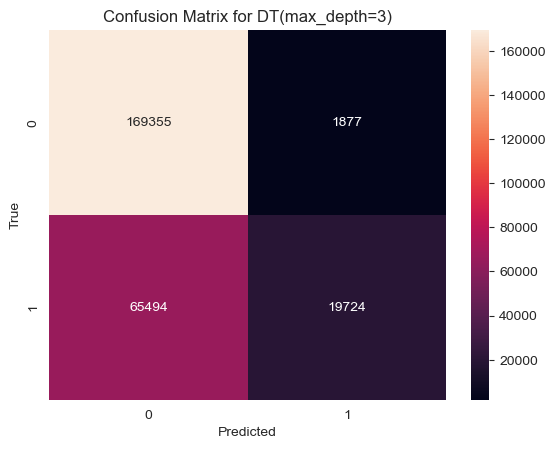

Classification Report for DT(max_depth=3):
              precision    recall  f1-score   support

       False       0.72      0.99      0.83    171232
        True       0.91      0.23      0.37     85218

    accuracy                           0.74    256450
   macro avg       0.82      0.61      0.60    256450
weighted avg       0.78      0.74      0.68    256450



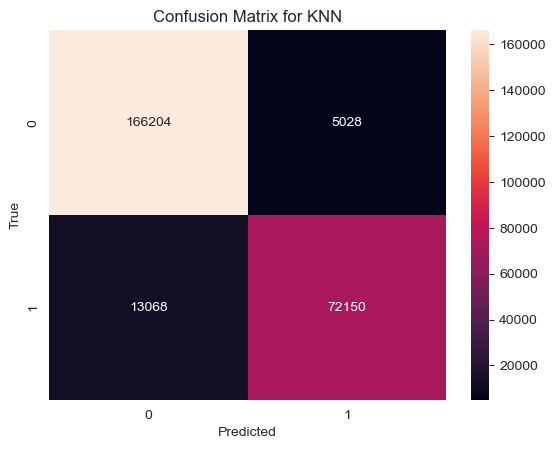

Classification Report for KNN:
              precision    recall  f1-score   support

       False       0.93      0.97      0.95    171232
        True       0.93      0.85      0.89     85218

    accuracy                           0.93    256450
   macro avg       0.93      0.91      0.92    256450
weighted avg       0.93      0.93      0.93    256450



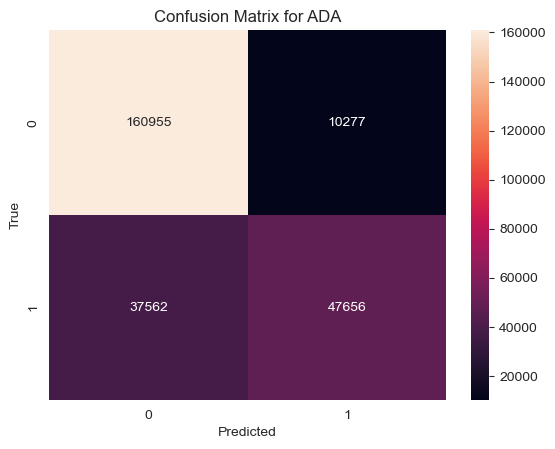

Classification Report for ADA:
              precision    recall  f1-score   support

       False       0.81      0.94      0.87    171232
        True       0.82      0.56      0.67     85218

    accuracy                           0.81    256450
   macro avg       0.82      0.75      0.77    256450
weighted avg       0.81      0.81      0.80    256450



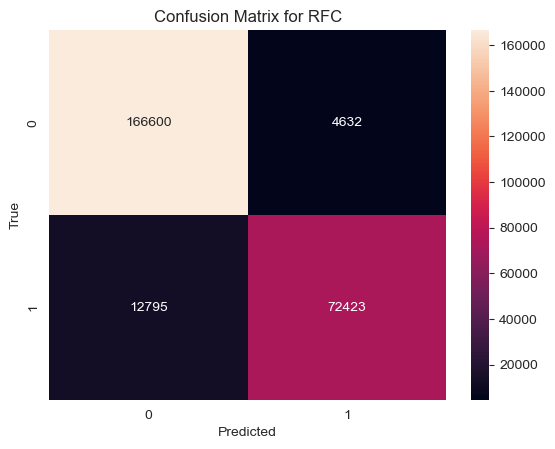

Classification Report for RFC:
              precision    recall  f1-score   support

       False       0.93      0.97      0.95    171232
        True       0.94      0.85      0.89     85218

    accuracy                           0.93    256450
   macro avg       0.93      0.91      0.92    256450
weighted avg       0.93      0.93      0.93    256450



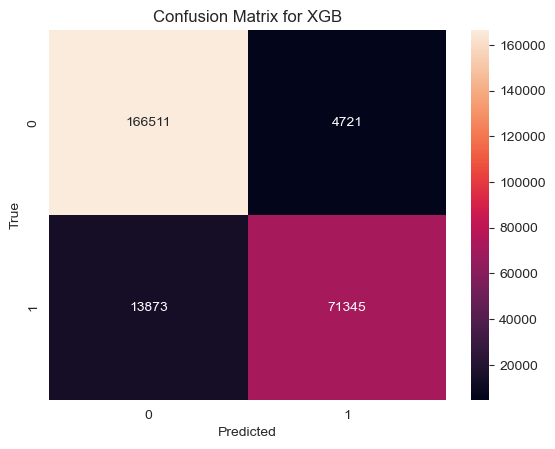

Classification Report for XGB:
              precision    recall  f1-score   support

       False       0.92      0.97      0.95    171232
        True       0.94      0.84      0.88     85218

    accuracy                           0.93    256450
   macro avg       0.93      0.90      0.92    256450
weighted avg       0.93      0.93      0.93    256450



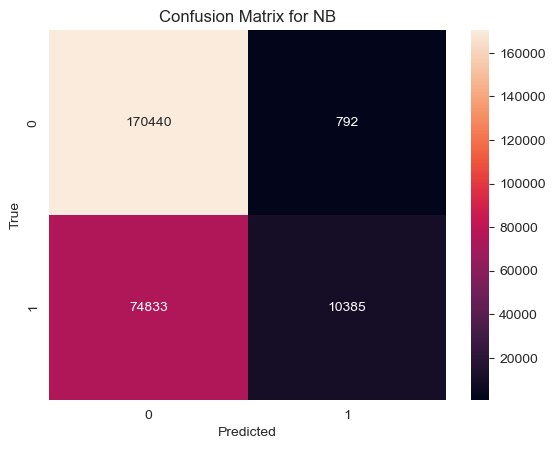

Classification Report for NB:
              precision    recall  f1-score   support

       False       0.69      1.00      0.82    171232
        True       0.93      0.12      0.22     85218

    accuracy                           0.71    256450
   macro avg       0.81      0.56      0.52    256450
weighted avg       0.77      0.71      0.62    256450



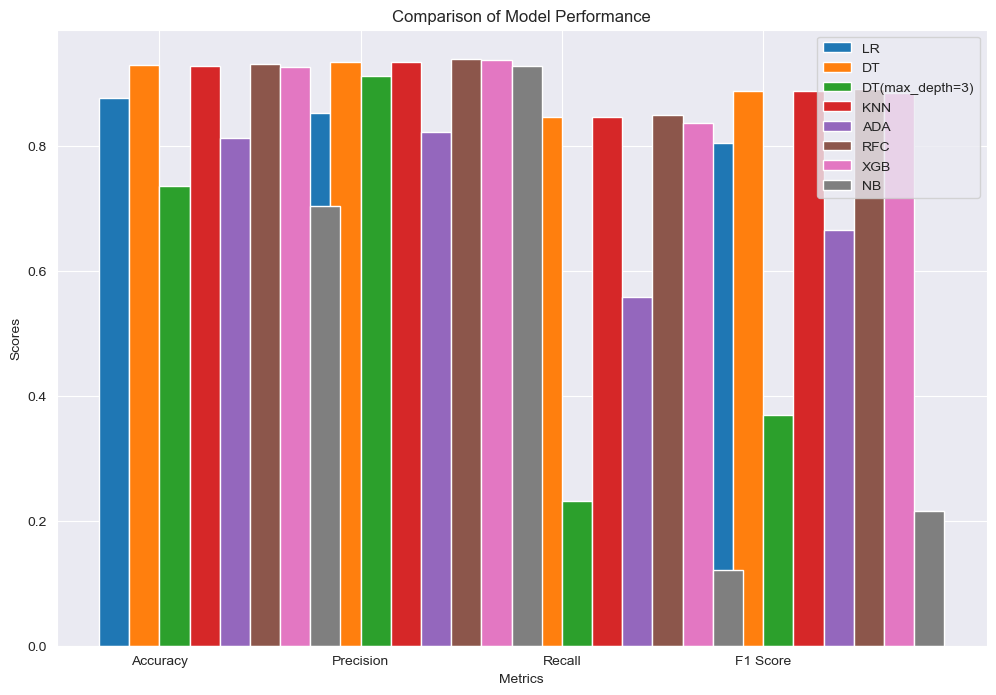

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # For confusion matrix visualization

# Assuming models dictionary is defined as provided and necessary models are imported

def evaluate_models(models, Xtrain, Xtest, Ytrain, Ytest):
    scores = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        # Predict
        predictions = model.predict(X_test)
        # Metrics
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='binary')
        recall = recall_score(y_test, predictions, average='binary')
        f1 = f1_score(y_test, predictions, average='binary')
        
        scores[name] = [accuracy, precision, recall, f1]
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, predictions)
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        # Classification Report
        print(f'Classification Report for {name}:')
        print(classification_report(y_test, predictions))
    
    return scores

# Plotting function remains the same
def plot_model_comparison(scores):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    x = np.arange(len(metrics))
    width = 0.15  # Adjust width to fit all models
    
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (name, scores) in enumerate(scores.items()):
        ax.bar(x + i*width, scores, width, label=name)
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Model Performance')
    ax.set_xticks(x + width / 2 * (len(scores)-1))
    ax.set_xticklabels(metrics)
    ax.legend()
    
    plt.show()

# Example usage:
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
scores = evaluate_models(models, X_train, X_test, y_train, y_test)
plot_model_comparison(scores)
